In [1]:
#%pip install tqdm
#%pip install ipywidgets 

import random
import time
import torch
import torch.nn as nn
import scipy.sparse as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

## Load Data

In [ ]:
train = pd.read_csv('train_interactions.csv')
test = pd.read_csv('test_interactions.csv')


train = train.sort_values(by=['user_id', 'review_age'])
test = test.sort_values(by=['user_id', 'review_age'])

print(f"Train: {len(train)}")
print(f"Test: {len(test)}")
train.head()

Train: 134745
Test: 41596


,user_id,book_id,rating,date_added,n_votes,review_age,sentiment
0,0,157993,5,2016-07-18 19:34:48+00:00,NaN,3004,0.574139
1,0,359079,4,2014-07-16 19:28:57+00:00,NaN,3737,0.527973
2,0,41684,4,2014-07-16 13:45:50+00:00,NaN,3738,0.527973
3,0,180617,4,2012-08-06 19:55:50+00:00,NaN,4446,0.527973
4,0,13023,3,2012-01-30 10:17:30+00:00,NaN,4636,0.406860


## Label Encoding

In [ ]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train['user_id_idx'] = le_user.fit_transform(train['user_id'].values)
train['book_id_idx'] = le_item.fit_transform(train['book_id'].values)
train_user_ids = train['user_id'].unique()
train_item_ids = train['book_id'].unique()

print(len(train_user_ids), len(train_item_ids))

# Ensure that the test set only contains users and books in the training 
test = test[(test['user_id'].isin(train_user_ids)) & (test['book_id'].isin(train_item_ids))]
print(len(test))

20798 14645
40174


In [ ]:
test['user_id_idx'] = le_user.transform(test['user_id'].values)
test['book_id_idx'] = le_item.transform(test['book_id'].values)

n_users = train['user_id_idx'].nunique()
n_items = train['book_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  20798
Number of unique Items :  14645


In [ ]:
latent_dim = 64  
n_layers = 3  

def convert_to_sparse_tensor(dok_mtrx):
    dok_mtrx_coo = dok_mtrx.tocoo().astype(np.float32)  
    values = dok_mtrx_coo.data  
    indices = np.vstack((dok_mtrx_coo.row, dok_mtrx_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = dok_mtrx_coo.shape

    dok_mtrx_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

    return dok_mtrx_sparse_tensor

## Define function for evaluation metrics

In [ ]:
def get_metrics(user_Embed_wts, book_Embed_wts, n_users, n_items, train_data, test_data, K):

    # Initialize user and item embeddings using pre-trained weights
    user_Embedding = nn.Embedding(user_Embed_wts.size()[0], user_Embed_wts.size()[1], _weight = user_Embed_wts)
    item_Embedding = nn.Embedding(book_Embed_wts.size()[0], book_Embed_wts.size()[1], _weight = book_Embed_wts)

    # Get unique user IDs in the test set
    test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())

    # Compute relevance score matrix based on user and item embeddings
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(book_Embed_wts,0, 1))

    # Initialize a sparse matrix R with interactions from the training data
    R = sp.dok_matrix((n_users, n_items), dtype = np.float32)
    R[train_data['user_id_idx'], train_data['book_id_idx']] = 1.0

    # Convert sparse matrix R to a sparse tensor
    R_tensor = convert_to_sparse_tensor(R)
    R_tensor_dense = R_tensor.to_dense()

    # Set non-interacted items in the relevance score matrix to negative infinity
    R_tensor_dense = R_tensor_dense*(-np.inf)
    R_tensor_dense = torch.nan_to_num(R_tensor_dense, nan=0.0)

    # Add the relevance score matrix and the non-interacted items matrix
    relevance_score = relevance_score + R_tensor_dense

    # Retrieve the top-K relevance scores and their corresponding indices
    topk_relevance_score = torch.topk(relevance_score, K).values
    topk_relevance_indices = torch.topk(relevance_score, K).indices

    # Convert top-K relevance indices to a DataFrame
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    # Group the test set by user ID and retrieve the list of interacted items
    test_interacted_items = test_data.groupby('user_id_idx')['book_id_idx'].apply(list).reset_index()

    # Merge the interacted items list with the top-K relevance indices DataFrame
    metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.book_id_idx, metrics_df.top_rlvnt_itm)]

    # Compute recall, precision, and hit list metrics
    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['book_id_idx']), axis = 1)
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    # Check if each recommended item is in the interacted item list
    def get_hit_list(book_id_idx, top_rlvnt_itm):
        return [1 if x in set(book_id_idx) else 0 for x in top_rlvnt_itm ]
    metrics_df['hit_list'] = metrics_df.apply(lambda x : get_hit_list(x['book_id_idx'], x['top_rlvnt_itm']), axis = 1)

    # Calculate the ideal DCG (IDCG) based on the number of interacted items and the hit list
    def get_dcg_idcg(book_id_idx, hit_list):
        idcg  = sum([1 / np.log1p(idx+1) for idx in range(min(len(book_id_idx),len(hit_list)))])
        dcg =  sum([hit / np.log1p(idx+1) for idx, hit in enumerate(hit_list)])
        return dcg/idcg
    metrics_df['ndcg'] = metrics_df.apply(lambda x : get_dcg_idcg(x['book_id_idx'], x['hit_list']), axis = 1)

    # Calculate the cumulative sum of hits in the hit list
    def get_cumsum(hit_list):
        return np.cumsum(hit_list)
    metrics_df['hit_list_cumsum'] = metrics_df.apply(lambda x : get_cumsum(x['hit_list']), axis = 1)

    # Calculate the mean average precision (MAP) for a user
    def get_map(book_id_idx, hit_list, hit_list_cumsum):
        return sum([hit_cumsum*hit/(idx+1) for idx, (hit, hit_cumsum) in enumerate(zip(hit_list, hit_list_cumsum))])/len(book_id_idx)
    metrics_df['map'] = metrics_df.apply(lambda x : get_map(x['book_id_idx'], x['hit_list'], x['hit_list_cumsum']), axis = 1)

    return topk_relevance_indices_df, metrics_df['recall'].mean(), metrics_df['precision'].mean(), metrics_df['ndcg'].mean(), metrics_df['map'].mean()

## Graph and Model Construction

In [ ]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers, latent_dim):
        super(LightGCN, self).__init__()
        self.data = data
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.init_embedding()
        # Constructs the normalized adjacency matrix for the user-item graph in sparse tensor form.
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda()

    def init_embedding(self):
        # Creates an embedding matrix E0 for both users and items, where each has a latent_dim dimensional embedding.
        self.E0 = nn.Embedding(self.n_users + self.n_items, self.latent_dim)
        # Initializes the embedding weights using Xavier uniform initialization
        nn.init.xavier_uniform_(self.E0.weight)
        # Convert embedding weights to Parameter
        self.E0.weight = nn.Parameter(self.E0.weight)

    # Creates and normalizes adjacency matrix for the bipartite graph and return its sparse tensor
    def get_A_tilda(self):
        # Initializes sparse dictionary-of-keys (DOK) matrix R to represent the user-item interaction matrix.
        R = sp.dok_matrix((self.n_users, self.n_items), dtype = np.float32)
        # Populates the matrix R with 1.0 at positions where interactions between users and items exist (i.e., where the user-item pair occurs).
        R[self.data['user_id_idx'], self.data['book_id_idx']] = 1.0

        # Create adjacency matrix for the bipartite graph
        adj_mat = sp.dok_matrix(
                (self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32
            )
        adj_mat = adj_mat.tolil()
        R = R.tolil()
        # user-to-item connections 
        adj_mat[: n_users, n_users :] = R
        # item-to-user connections 
        adj_mat[n_users :, : n_users] = R.T
        adj_mat = adj_mat.todok()

        # Normalize adjacency matrix using the inverse degree matrix.
        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        # normalizes the rows of the adjacency matrix
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        # normalizes the columns of adjacency matrix
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)

        # Convert the dok_matrix to sparse tensor.

        norm_adj_mat_coo = norm_adj_mat.tocoo().astype(np.float32)
        values = norm_adj_mat_coo.data
        indices = np.vstack((norm_adj_mat_coo.row, norm_adj_mat_coo.col))

        i = torch.LongTensor(indices)
        v = torch.FloatTensor(values)
        shape = norm_adj_mat_coo.shape

        norm_adj_mat_sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))

        return norm_adj_mat_sparse_tensor

    # propagate user and item embeddings through the network 
    def propagate_through_layers(self):
        all_layer_embedding = [self.E0.weight]
        E_lyr = self.E0.weight

        for layer in range(self.n_layers):
            E_lyr = torch.sparse.mm(self.norm_adj_mat_sparse_tensor, E_lyr)
            all_layer_embedding.append(E_lyr)

        all_layer_embedding = torch.stack(all_layer_embedding)
        mean_layer_embedding = torch.mean(all_layer_embedding, axis = 0)

        final_user_Embed, final_item_Embed = torch.split(mean_layer_embedding, [n_users, n_items])
        initial_user_Embed, initial_item_Embed = torch.split(self.E0.weight, [n_users, n_items])

        return final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed

    # define the forward pass of the model, compute the final embeddings for given users and items
    def forward(self, users, pos_items, neg_items):
        final_user_Embed, final_item_Embed, initial_user_Embed, initial_item_Embed = self.propagate_through_layers()

        users_emb, pos_emb, neg_emb = final_user_Embed[users], final_item_Embed[pos_items], final_item_Embed[neg_items]
        userEmb0,  posEmb0, negEmb0 = initial_user_Embed[users], initial_item_Embed[pos_items], initial_item_Embed[neg_items]

        return users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0

In [182]:
lightGCN = LightGCN(train, n_users, n_items, n_layers, latent_dim)
print("Size of Learnable Embedding : ", list(lightGCN.parameters())[0].size())
# You should find that the number of embeddings is the sum of the number of unqiue users and the number of unique items

Size of Learnable Embedding :  torch.Size([35443, 64])


## Model Training and Evaluation

In [183]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0):
    # Compute regularization loss
    reg_loss = (1/2)*(userEmb0.norm().pow(2) +
                    posEmb0.norm().pow(2)  +
                    negEmb0.norm().pow(2))/float(len(users))

    # Compute scores for positive and negative items
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)

    # Compute BPR loss using softplus function
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    return loss, reg_loss

In [ ]:
def data_loader(data, batch_size, n_usr, n_itm):
    # Group interactions by user ID and sample negative items
    interected_items_df = data.groupby('user_id_idx')['book_id_idx'].apply(list).reset_index()

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)

    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])
    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')

    # Select positive and negative items for each user
    pos_items = interected_items_df['book_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['book_id_idx'].apply(lambda x: sample_neg(x)).values

    return list(users), list(pos_items), list(neg_items)

In [199]:
optimizer = torch.optim.Adam(lightGCN.parameters(), lr = 0.005)
EPOCHS = 30
BATCH_SIZE = 1024
DECAY = 0.0001
K = 10

In [ ]:
loss_list_epoch = []
MF_loss_list_epoch = []
reg_loss_list_epoch = []

recall_list = []
precision_list = []
ndcg_list = []
map_list = []

train_time_list = []
eval_time_list = []

for epoch in tqdm(range(EPOCHS)):
    n_batch = int(len(train)/BATCH_SIZE)

    # Initialization
    final_loss_list = []
    MF_loss_list = []
    reg_loss_list = []
    best_ndcg = -1
    train_start_time = time.time()

    lightGCN.train()

    for batch_idx in range(n_batch):
        # Reset gradients
        optimizer.zero_grad()
        # Load data for the current batch
        users, pos_items, neg_items = data_loader(train, BATCH_SIZE, n_users, n_items)
        # Perform forward pass through the model
        users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = lightGCN.forward(users, pos_items, neg_items)
        # Compute BPR loss and regularization loss
        mf_loss, reg_loss = bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
        reg_loss = DECAY * reg_loss  # Apply weight decay
        # Combine losses to get the final loss
        final_loss = mf_loss + reg_loss
        # Perform backward pass and update model parameters
        final_loss.backward()
        optimizer.step()
        # Record losses for monitoring
        final_loss_list.append(final_loss.item())
        MF_loss_list.append(mf_loss.item())
        reg_loss_list.append(reg_loss.item())


    train_end_time = time.time()
    train_time = train_end_time - train_start_time

    # model evaluation
    lightGCN.eval()
    with torch.no_grad():
        final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
        pred, test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)


    eval_time = time.time() - train_end_time

    # calculate and append the mean values of various loss and evaluation metrics for each epoch to their respective lists.
    loss_list_epoch.append(round(np.mean(final_loss_list),4))
    MF_loss_list_epoch.append(round(np.mean(MF_loss_list),4))
    reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

    recall_list.append(round(test_topK_recall,4))
    precision_list.append(round(test_topK_precision,4))
    ndcg_list.append(round(test_topK_ndcg,4))
    map_list.append(round(test_topK_map,4))

    train_time_list.append(train_time)
    eval_time_list.append(eval_time)

  0%|          | 0/30 [00:00<?, ?it/s]

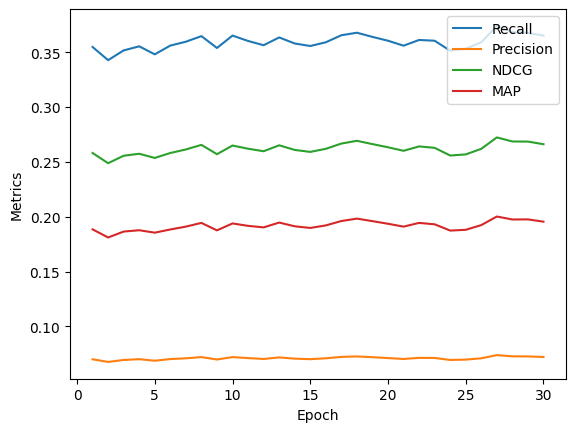

In [201]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, recall_list, label='Recall')
plt.plot(epoch_list, precision_list, label='Precision')
plt.plot(epoch_list, ndcg_list, label='NDCG')
plt.plot(epoch_list, map_list, label='MAP')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

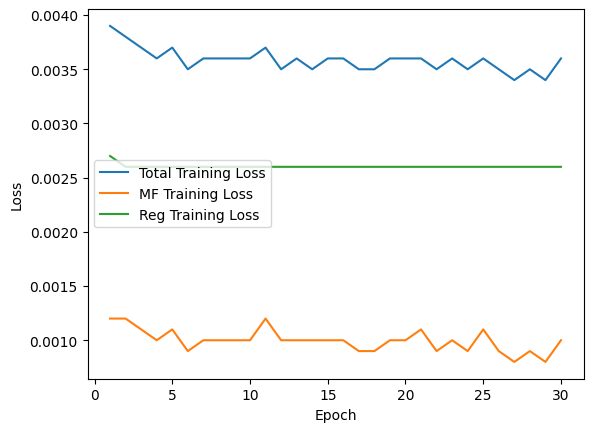

In [202]:
plt.plot(epoch_list, loss_list_epoch, label='Total Training Loss')
plt.plot(epoch_list, MF_loss_list_epoch, label='MF Training Loss')
plt.plot(epoch_list, reg_loss_list_epoch, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [203]:
print("Last Epoch's Test Data Recall -> ", recall_list[-1])
print("Last Epoch's Test Data Precision -> ", precision_list[-1])
print("Last Epoch's Test Data NDCG -> ", ndcg_list[-1])
print("Last Epoch's Test Data MAP -> ", map_list[-1])

print("Last Epoch's Train Data Loss -> ", loss_list_epoch[-1])

Last Epoch's Test Data Recall ->  0.3651
Last Epoch's Test Data Precision ->  0.0722
Last Epoch's Test Data NDCG ->  0.2661
Last Epoch's Test Data MAP ->  0.1955
Last Epoch's Train Data Loss ->  0.0036


## Evaluate on Test Set

In [204]:
with torch.no_grad():
    final_user_Embed, final_item_Embed, initial_user_Embed,initial_item_Embed = lightGCN.propagate_through_layers()
    pred, test_topK_recall,  test_topK_precision, test_topK_ndcg, test_topK_map  = get_metrics(final_user_Embed, final_item_Embed, n_users, n_items, train, test, K)

In [205]:
def eval_test(row, test):
    user_df = test[test.user_id == row['user_ID']]['book_id_idx'].unique().tolist()
    intersect = set(row.top_rlvnt_itm).intersection(set(user_df))

    return True if intersect else False
    

In [206]:
pred['eval'] = pred.apply(lambda row: eval_test(row, test), axis=1)
pred

,user_ID,top_rlvnt_itm,eval
0,0,"[2151, 836, 314, 1548, 186, 275, 475, 3970, 10...",False
1,1,"[3698, 3695, 934, 933, 914, 2, 1458, 3694, 193...",False
2,2,"[84, 449, 101, 100, 354, 807, 95, 85, 102, 2886]",False
3,3,"[22, 286, 58, 2558, 1458, 704, 1275, 4544, 276...",False
4,4,"[357, 22, 1602, 6548, 193, 858, 747, 2898, 78,...",True
...,...,...,...
20793,20793,"[333, 354, 1602, 1332, 357, 1286, 58, 78, 1282...",True
20794,20794,"[176, 1010, 280, 78, 354, 836, 186, 333, 116, ...",True
20795,20795,"[354, 2806, 673, 2028, 81, 11, 84, 2886, 560, 1]",True
20796,20796,"[78, 299, 1832, 435, 1458, 2886, 354, 1501, 91...",False


In [210]:
true_count = pred['eval'].value_counts().get(True, 0)
false_count = pred['eval'].value_counts().get(False, 0)

# Print in markdown format
print(f"True: {true_count}")
print(f"False: {false_count}")
print(f"Accuracy: {true_count/(true_count + false_count)}")

True: 11182
False: 9616
Accuracy: 0.5376478507548803
